In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
import datetime
#from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from matplotlib import pyplot
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [3]:
# #load dataset
# series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)#, date_parser=parser)
# series

In [4]:
import pandas as pd
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
series2 = pd.read_csv('data.csv', header=0, sep=',', parse_dates=[0], index_col=0, squeeze=True,date_parser=dateparse)
series2.drop('Num_Covid_Cases', inplace=True, axis=1)
series = series2
series

,Num_Flights
Timestamp,
2020-01-22,2731
2020-01-23,3357
2020-01-24,3373
2020-01-25,2912
2020-01-26,2287
...,...
2022-01-27,5576
2022-01-28,5531
2022-01-29,4177


In [5]:
# transform data to be stationary x.astype(int)
raw_values = series['Num_Flights'].astype(int)
diff_values = difference(raw_values, 1)

In [6]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [7]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [8]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [9]:
# repeat experiment
repeats = 3 #30
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3, 4) #3000
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

1) Test RMSE: 557.067
2) Test RMSE: 552.335
3) Test RMSE: 572.090


In [65]:
series['Num_Flights'][-12:], predictions

(Timestamp
 2022-01-20    5452
 2022-01-21    5800
 2022-01-22    4845
 2022-01-23    4605
 2022-01-24    5134
 2022-01-25    5444
 2022-01-26    5262
 2022-01-27    5576
 2022-01-28    5531
 2022-01-29    4177
 2022-01-30    4273
 2022-01-31    4736
 Name: Num_Flights, dtype: int64,
 [5342.449187472463,
  5539.896470852196,
  5893.3165324777365,
  4863.854312889278,
  4622.995927348733,
  5197.524359293282,
  5518.176777668297,
  5312.208360157907,
  5642.757387697697,
  5585.520096391439,
  4140.137725010514,
  4277.033293962479])

In [64]:
from sklearn.metrics import r2_score
score = r2_score(series['Num_Flights'][-12:], predictions)
score

-0.25106363901658746

             rmse
count    3.000000
mean   560.497449
std     10.314113
min    552.335381
25%    554.701389
50%    557.067398
75%    564.578484
max    572.089569


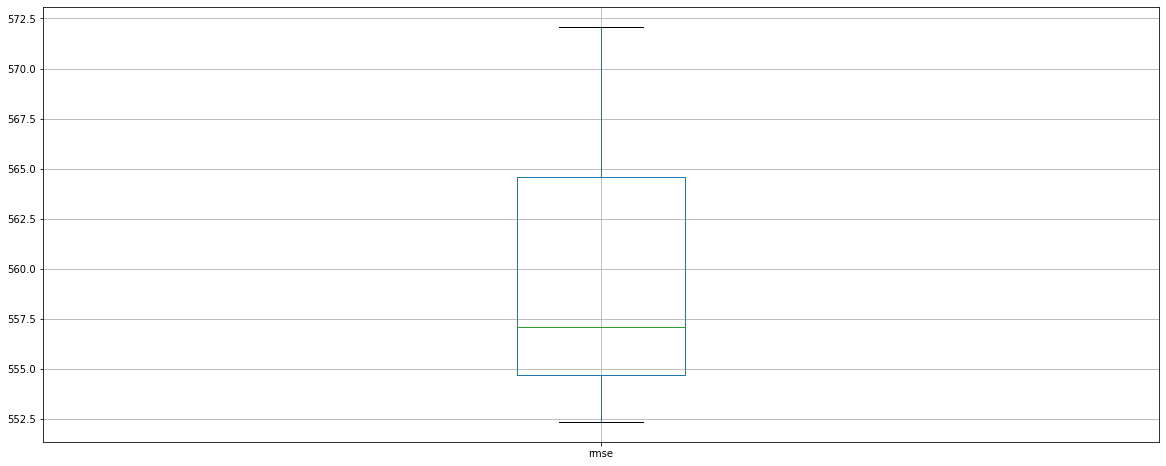

In [10]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
plt.figure(figsize=(20,8))
results.boxplot()
pyplot.show()

Text(0, 0.5, 'Number of Flights')

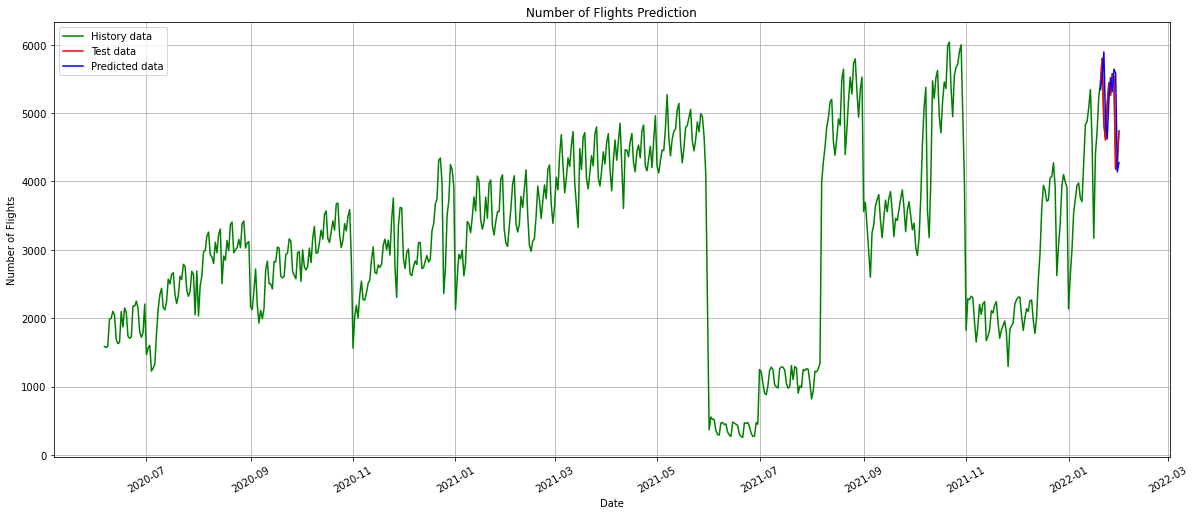

In [54]:
plt.figure(figsize=(20,8))
plt.plot(series.index[-600:], series['Num_Flights'].tail(600), color='green', label='History data')#, marker = 'x')
plt.plot(series.index[724:], series['Num_Flights'][724:], color='red', label='Test data')#, marker = '.')
plt.plot(series.index[724:], predictions, color='blue', label='Predicted data')#, marker = '*')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()
plt.title('Number of Flights Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Flights')

In [55]:
lstm_univariate_df = pd.DataFrame(predictions)
lstm_univariate_df.to_csv('lstm_univariate_predictions.csv')